In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
import torch
import torch.nn as nn
from matplotlib.colors import Normalize

#### Get the data and visualize it

In [2]:
file_path = './burgers.npy' 
# change path accordingly

In [3]:
with open(file_path, 'rb') as f:
    usol =  np.load(f)

/tmp/ipykernel_14043/3600534733.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


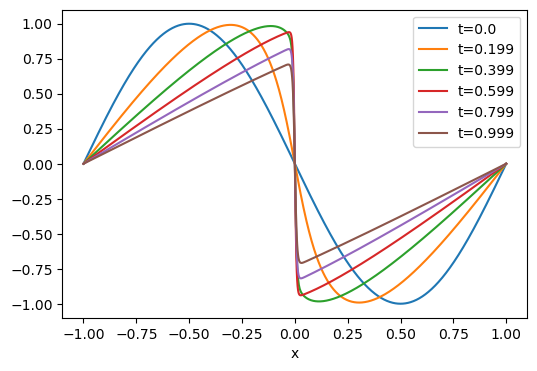

In [6]:
# Visualize some of the data, for some values of t
fig, ax = plt.subplots(1,figsize=(6,4))
for j in [0,199,399,599,799,999]:
    ax.plot(np.linspace(-1, 1, 1000), usol[j,:], label=f't={j/usol.shape[0]}')
ax.set_xlabel('x')
ax.legend()
fig.show()

# the first dimension is t (usol[t,:] is all x at time t)
# second dimension is x 

#### Neural Network Architecture

In [12]:
class ScalingLayer(nn.Module):
    def __init__(self, scale_init_value=1, bias_init_value=0):
        super().__init__()
        self.scale = nn.Parameter(torch.FloatTensor([scale_init_value]))
        self.bias = nn.Parameter(torch.FloatTensor([bias_init_value]))

    def forward(self, input):
        return input * self.scale + self.bias
    
    
class U(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()
        
        self.layers = nn.ModuleList()
        self.layers.append(ScalingLayer())
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
class F(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()
        
        self.layers = nn.ModuleList()
        self.layers.append(ScalingLayer())
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

#### Get Collocation points in $x\in [-1,1]$ and $t\in [0,1]$

In [13]:
def generate_latin_hyper_c_sampling(Nd=10000):
    sampler = qmc.LatinHypercube(d=2)
    sample_pos = sampler.random(n=Nd//2) # [0,1)^2
    sample_neg = sampler.random(n=Nd//2) # [0,1)^2
    sample_neg[:,1] = -sample_neg[:,1]

    return np.vstack([sample_pos, sample_neg])

In [14]:
collocation_p = generate_latin_hyper_c_sampling(10**4)

In [15]:
collocation_p

array([[ 0.70195818,  0.68421923],
       [ 0.64575705,  0.12388968],
       [ 0.51604761,  0.42337355],
       ...,
       [ 0.9527078 , -0.21207024],
       [ 0.47030973, -0.49824268],
       [ 0.99717206, -0.30422579]])

In [16]:
# first column is in range [0,1] (represents t)
assert collocation_p[:,0].min() > 0
assert collocation_p[:,0].max() < 1

# second column is in range [-1,1] (represents x)
assert collocation_p[:,1].min() > -1
assert collocation_p[:,1].max() < 1

/tmp/ipykernel_14043/1262115449.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


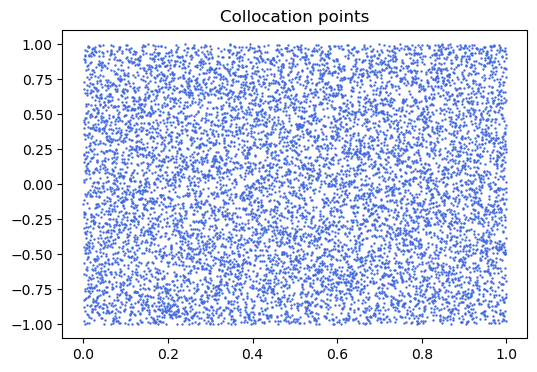

In [17]:
fig, ax = plt.subplots(1,figsize=(6,4))
ax.scatter(collocation_p[:,0], collocation_p[:,1], s=0.5, color='royalblue')
ax.set_title('Collocation points')
fig.show()

### Get training data

In [18]:
def get_train_data(n, t, usol, noise=5e-3):
    '''
    Return n training data at a constant time t, along the whole x axis with an additive 
    noise ~ N(0,1)*eps
    '''
    t_index = int(t*usol.shape[1])
    
    x_indices = np.arange(0, usol.shape[1], usol.shape[1]//n)
    u_vals = usol[t_index, x_indices]
    u_vals = u_vals.reshape(-1,1)
    
    x_vals = ((x_indices * (2/1000)) -1)
    x_vals = x_vals.reshape(-1,1)
    t_vals = np.array([t]*x_vals.shape[0])
    t_vals = t_vals.reshape(-1,1)
    
    u_vals += (np.random.normal(loc=0.0, scale=1.0, size=u_vals.shape[0]) * noise).reshape(-1,1)
    
    return np.concatenate([t_vals, x_vals], axis=1), u_vals

In [19]:
train_data_t05, target_t05 = get_train_data(100, 0.5, usol, noise=5e-3)
train_data_t095, target_t095 = get_train_data(100, 0.95, usol, noise=5e-3)
train_data_t015, target_t015 = get_train_data(100, 0.15, usol, noise=5e-3)
train_data_t025, target_t025 = get_train_data(100, 0.25, usol, noise=5e-3)

# concatenate all training data
train_data = np.concatenate([train_data_t05, train_data_t095, train_data_t015, train_data_t025], axis=0)
train_targets = np.concatenate([target_t05, target_t095, target_t015, target_t025], axis=0)

/tmp/ipykernel_14043/1838387595.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


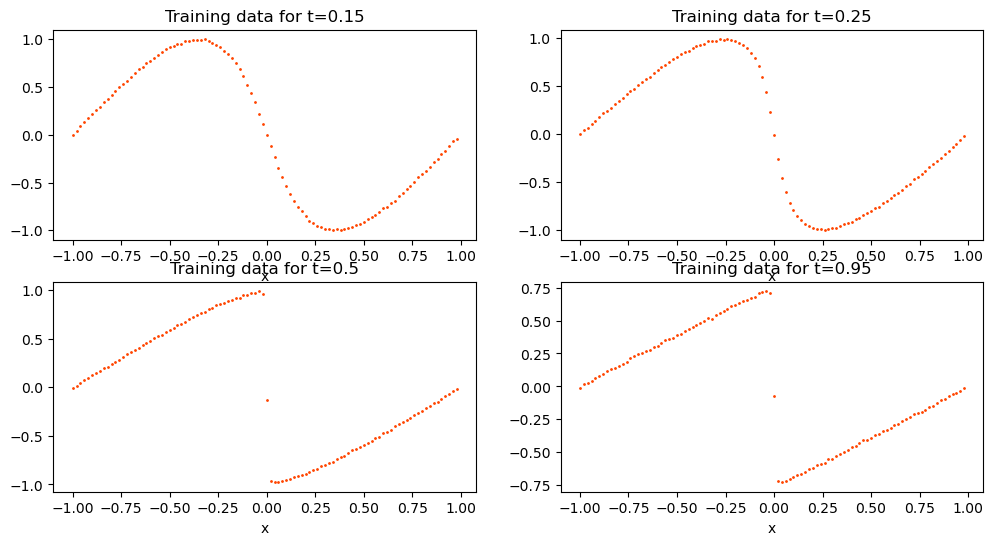

In [20]:
# Visualize the training data
fig, ax = plt.subplots(2,2, figsize=(12,6))
ax[0,0].scatter(train_data_t015[:,1], target_t015[:,0], s=1, color='orangered')
ax[0,0].set_title('Training data for t=0.15')
ax[0,0].set_xlabel('x')

ax[0,1].scatter(train_data_t025[:,1], target_t025[:,0], s=1, color='orangered')
ax[0,1].set_title('Training data for t=0.25')
ax[0,1].set_xlabel('x')

ax[1,0].scatter(train_data_t05[:,1], target_t05[:,0], s=1, color='orangered')
ax[1,0].set_title('Training data for t=0.5')
ax[1,0].set_xlabel('x')

ax[1,1].scatter(train_data_t095[:,1], target_t095[:,0], s=1, color='orangered')
ax[1,1].set_title('Training data for t=0.95')
ax[1,1].set_xlabel('x')
fig.show()

In [21]:
print(train_data.shape)
assert train_data[:,0].min() >= 0
assert train_data[:,0].max() <= 1
assert train_data[:,1].min() >= -1
assert train_data[:,1].max() <= 1

(400, 2)


In [22]:
def get_boundary_points(n=100):
    '''
    Returns n data for each boundary and initial conditions
    '''
    sampler = qmc.LatinHypercube(d=1)
    sample_pos = sampler.random(4*n)
    
    # initial conditions
    u_initial = lambda x: -np.sin(np.pi * x)
    
    # (t,1) boundary
    top_b = sample_pos[:100]
    top_b = np.concatenate([top_b, np.ones_like(top_b)],axis=1)
    top_b_target = np.zeros((top_b.shape[0],1))
    # (t, -1) boundary
    bot_b = sample_pos[100:200]
    bot_b = np.concatenate([bot_b, np.ones_like(bot_b)*-1],axis=1)
    bot_b_target = np.zeros((bot_b.shape[0],1))
    
    # initial conditions
    x_b = sample_pos[200:300]
    x_b = np.concatenate([np.zeros_like(x_b), x_b],axis=1)
    x_b_target = u_initial(x_b[:,1]).reshape(-1,1)

    
    negx_b = -sample_pos[300:]
    negx_b = np.concatenate([np.zeros_like(negx_b), negx_b],axis=1)
    negx_b_target = u_initial(negx_b[:,1]).reshape(-1,1)
    
    return np.concatenate([top_b, bot_b, x_b, negx_b],axis=0), np.concatenate([top_b_target, 
                                                                               bot_b_target, 
                                                                               x_b_target, 
                                                                              negx_b_target], axis=0)

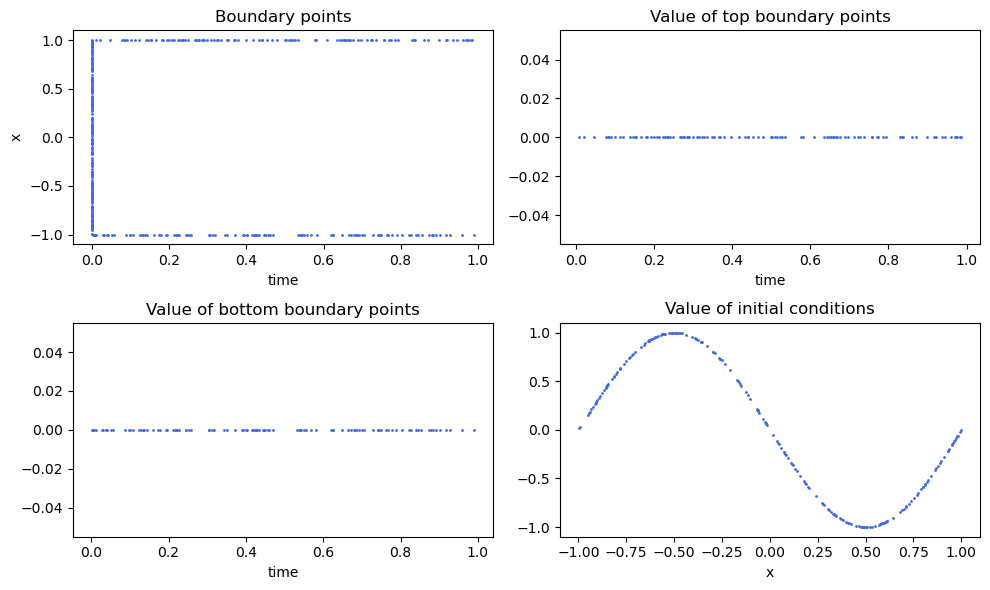

In [23]:
fig, ax = plt.subplots(2,2, figsize=(10,6))

boundary_points, boundary_targets = get_boundary_points(100)

ax[0,0].scatter(boundary_points[:,0], boundary_points[:,1], s=1.0, color='royalblue')
ax[0,0].set_title('Boundary points')
ax[0,0].set_xlabel('time')
ax[0,0].set_ylabel('x')

ax[0,1].scatter(boundary_points[:100,0], boundary_targets[:100], s=1.0, color='royalblue')
ax[0,1].set_title('Value of top boundary points')
ax[0,1].set_xlabel('time')

ax[1,0].scatter(boundary_points[100:200,0], boundary_targets[100:200], s=1.0, color='royalblue')
ax[1,0].set_title('Value of bottom boundary points')
ax[1,0].set_xlabel('time')

ax[1,1].scatter(boundary_points[200:,1], boundary_targets[200:], s=1.0, color='royalblue')
ax[1,1].set_title('Value of initial conditions')
ax[1,1].set_xlabel('x')

fig.tight_layout()

#### Training

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# put data on device
collocation_p = torch.Tensor(collocation_p).to(device).requires_grad_(True)
boundary_points = torch.Tensor(boundary_points).to(device)
boundary_targets = torch.Tensor(boundary_targets).to(device)
train_data = torch.Tensor(train_data).to(device)
train_targets = torch.Tensor(train_targets).to(device)

In [25]:
# if you want to use mini-batches (it slows down a lot, CPU becomes a bottleneck on Kaggle)
# import torch.utils.data as data_utils

# collocation_dataset = data_utils.TensorDataset(collocation_p)
# collocation_dataloader = data_utils.DataLoader(collocation_dataset, batch_size=2048, shuffle=True)

In [55]:
# initialize the networks and put them on the device
u = U(2,1, [20]*8)
u = u.to(device)

f = F(3,1, [20]*8)
f = f.to(device)

In [56]:
# Known viscosity hyperparam
v = 1 / (100 * np.pi)

In [57]:
def get_loss(boundary_points, boundary_targets, collocation_p, train_data, train_targets, lambdas):
    '''
    Computes and returns the boundary, physics and data loss.
    '''
    lambda1, lambda2, lambda3 = lambdas[0], lambdas[1], lambdas[2]
    # boundary loss -------
    u_b = u(boundary_points)
    loss1 = nn.MSELoss()(u_b, boundary_targets)
    

    # Physics loss -------
    u_p = u(collocation_p)
    dudxt = torch.autograd.grad(u_p, collocation_p, torch.ones_like(u_p), create_graph=True)[0]
    dudt = dudxt[:,0]
    dudx = dudxt[:,1]
    
    du2dx2 = torch.autograd.grad(dudxt, collocation_p, 
                                 torch.ones_like(dudxt), create_graph=True)[0][:,1]
    
    f_input = torch.cat([u_p,dudt.reshape(-1,1),dudx.reshape(-1,1)], axis=1)
    f_p = f(f_input)
    
    loss2 = nn.MSELoss()(-dudt.reshape(-1,1) + f_p + v * du2dx2.reshape(-1,1), torch.zeros_like(dudt.reshape(-1,1)))
    
    # Datapoint loss -------
    u_n = u(train_data)
    loss3 = nn.MSELoss()(u_n, train_targets)
    
    loss = lambda1*loss1 + lambda2*loss2  + lambda3*loss3
    return loss, loss1, loss2, loss3

In [58]:
def plot_solution(usol, u, f, mesh_size=10**2):
    '''
    Plot the surrogate solution, slices of the solution and the unknown term.
    '''
    
    # Compute u, dudx and F(u, dudx, dudt) to plot the true, estimated and learned unknown component N_k
    # The unknown component should be: -u * dudx
    x_points = (torch.linspace(-1,1,1000)).reshape(-1,1)
    t_points = (torch.ones_like(x_points)*0.75).reshape(-1,1)
    tx_points = torch.cat([t_points, x_points], axis=1).to(device).requires_grad_(True)
    
    u_plot = u(tx_points)
    
    dudxt_plot = torch.autograd.grad(u_plot, tx_points, torch.ones_like(u_plot), create_graph=True)[0]
    dudt_plot = dudxt_plot[:,0].reshape(-1,1)
    dudx_plot = dudxt_plot[:,1].reshape(-1,1)
    f_input_plot = torch.cat([u_plot, dudt_plot,dudx_plot], axis=1)
    f_plot = f(f_input_plot)
    
    # Compute dudx from the true solution u using finite difference
    # We consider the timestep t=0.75 so that the result is interpretable
    # and it is a timestep without any training data 
    true_u = usol[750,:]
    dudx_upwind = np.zeros((1000,1))
    
    dx = 2 / 1000
    for i in range(1, true_u.shape[0]-1):
            if true_u[i] >= 0:
                    dudx_upwind[i] = (true_u[i] - true_u[i-1]) / dx
            else:
                    dudx_upwind[i] = (true_u[i+1] - true_u[i]) / dx
    
    with torch.no_grad():
            # Get a meshgrid of points to display an image of the solution u in the
            # domain x=[-1,1] and t=[0,1]
            t_phys = np.linspace(0, 1, mesh_size)
            x_phys = np.linspace(-1, 1, mesh_size)
            x_mesh, t_mesh = np.meshgrid(x_phys, t_phys)

            coordinates = np.vstack((t_mesh.flatten(), x_mesh.flatten())).T
            coordinates = torch.Tensor(coordinates).to(device)
            
            u_p = u(coordinates).detach().cpu().numpy()
            u_mesh = u_p.reshape(x_mesh.shape)

            data_min = np.min(u_p)
            data_max = np.max(u_p)

            # Contour plot
            fig, ax = plt.subplots(2,2,figsize=(12,6))
            norm = Normalize(vmin=data_min, vmax=data_max)
            img = ax[0,0].imshow(u_mesh.T, cmap='viridis', 
                                 aspect='auto', 
                                 extent=[0, 1, 1, -1])
            fig.colorbar(img, ax=ax[0,0])

            ax[0,0].set_xlabel('t')
            ax[0,0].set_ylabel('x')
            ax[0,0].set_title('Contour plot of the Viscous Burgers Equation Approximation')
            
            # Slices
            # Visualize some of u predictions, for some values of t
            colors = ['royalblue', 'forestgreen', 'darkorange', 'firebrick']
            for i,(j,k) in enumerate(zip([0,500,750,999], [0,50,75,99])):
                ax[0,1].plot(np.linspace(-1, 1, 1000), usol[j,:], 
                             label=f't={j/usol.shape[0]}', color=colors[i])
                ax[0,1].plot(np.linspace(-1, 1, 100), 
                             u_mesh[k,:], linestyle='--', color=colors[i])
            ax[0,1].set_xlabel('x')
            ax[0,1].legend()
            fig.show()
            
            # plot the unknown term learned by F vs the true interaction
            expected = -(u_plot * dudx_plot).detach().cpu().numpy()
            ax[1,0].plot(np.linspace(-0.25, 0.25, 250), expected[375:625], label='Expected unknown')
            ax[1,0].plot(np.linspace(-0.25, 0.25, 250), f_plot.detach().cpu().numpy()[375:625], label='F', linestyle='--')
            ax[1,0].plot(np.linspace(-0.25, 0.25, 250), (-true_u.reshape(-1,1)*dudx_upwind)[375:625], label='True unknown')
            ax[1,0].legend()
            ax[1,0].set_title('Unknown term at time t=0.75')

            
            plt.show()
            return fig
    

[0/10001] Boundary L: 0.391814649105072, Phys L: 0.21779780089855194, Data L: 0.5427181720733643


/tmp/ipykernel_14043/2272388903.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


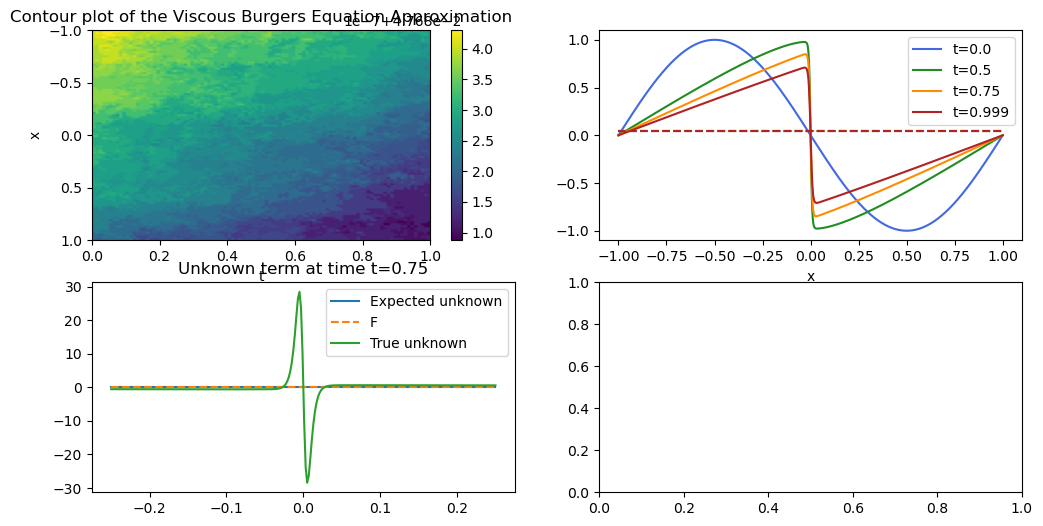

[1000/10001] Boundary L: 0.006855607032775879, Phys L: 0.0008425811538472772, Data L: 0.010353025048971176


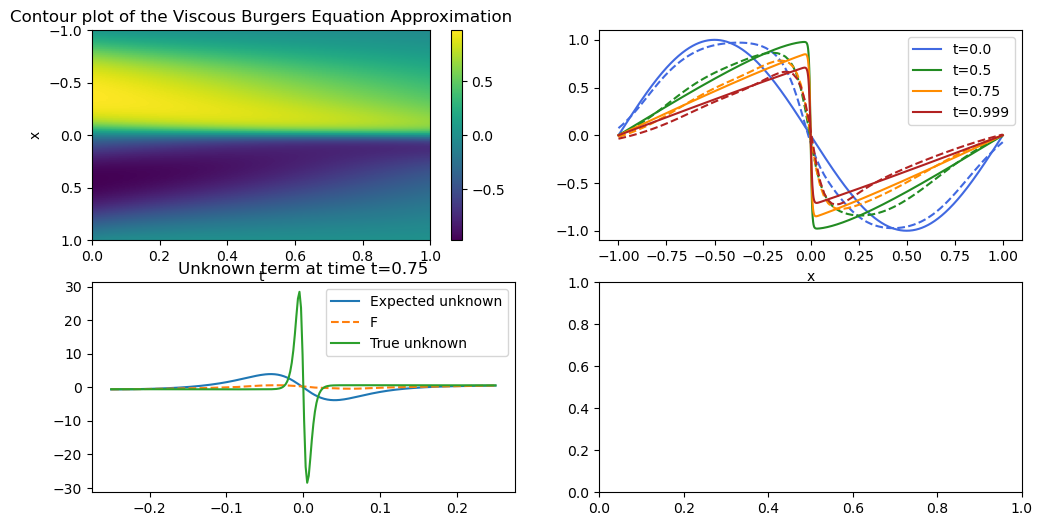

[2000/10001] Boundary L: 0.0014544918667525053, Phys L: 0.0004434253496583551, Data L: 0.005132457707077265


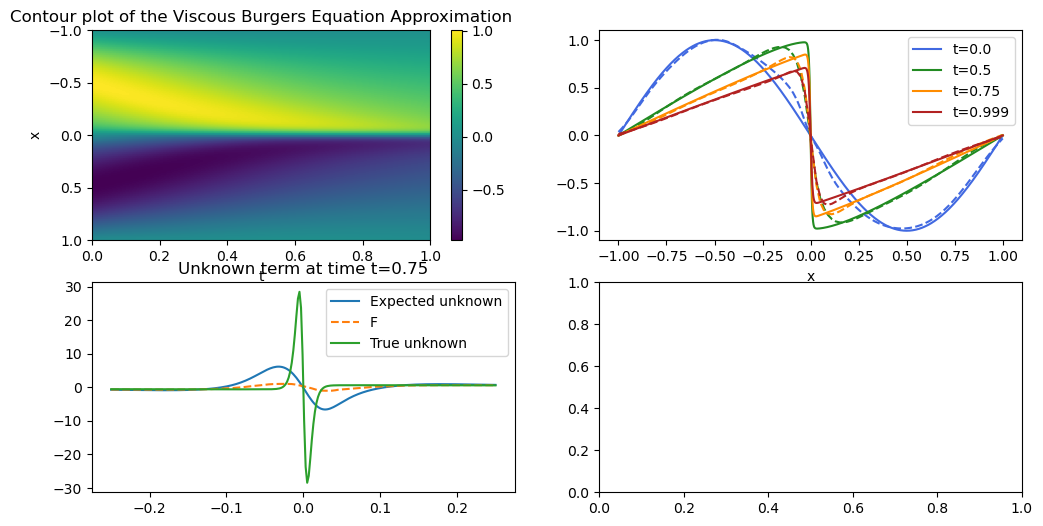

[3000/10001] Boundary L: 0.0006017793784849346, Phys L: 0.028467675670981407, Data L: 0.0031725489534437656


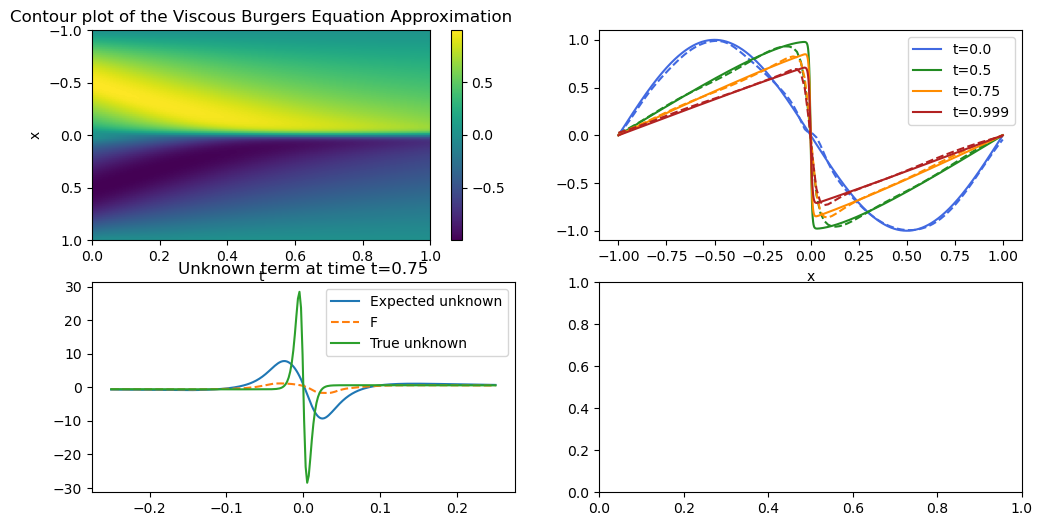

[4000/10001] Boundary L: 0.00012972902914043516, Phys L: 0.00022252695634961128, Data L: 0.0026410098653286695


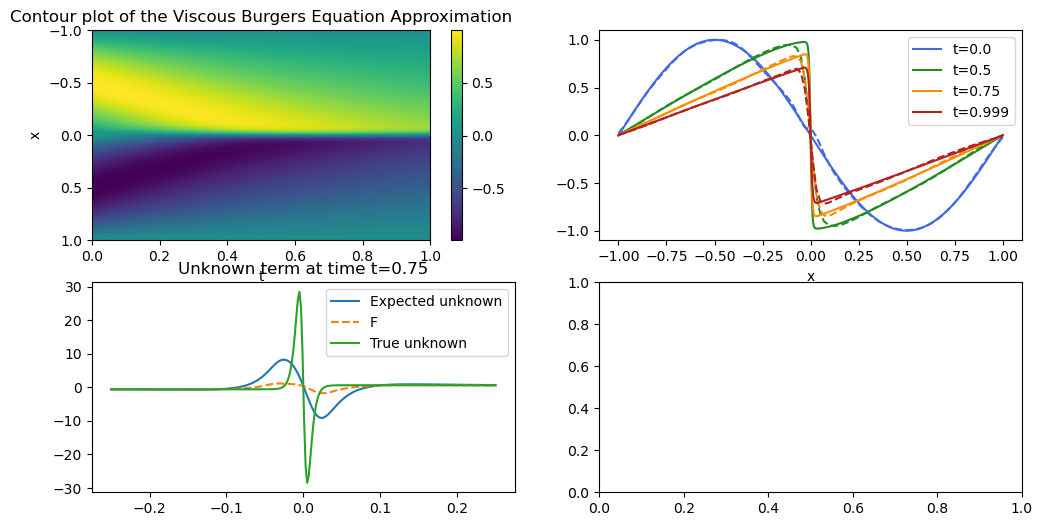

[5000/10001] Boundary L: 0.00013811886310577393, Phys L: 0.0004092917370144278, Data L: 0.0023291390389204025


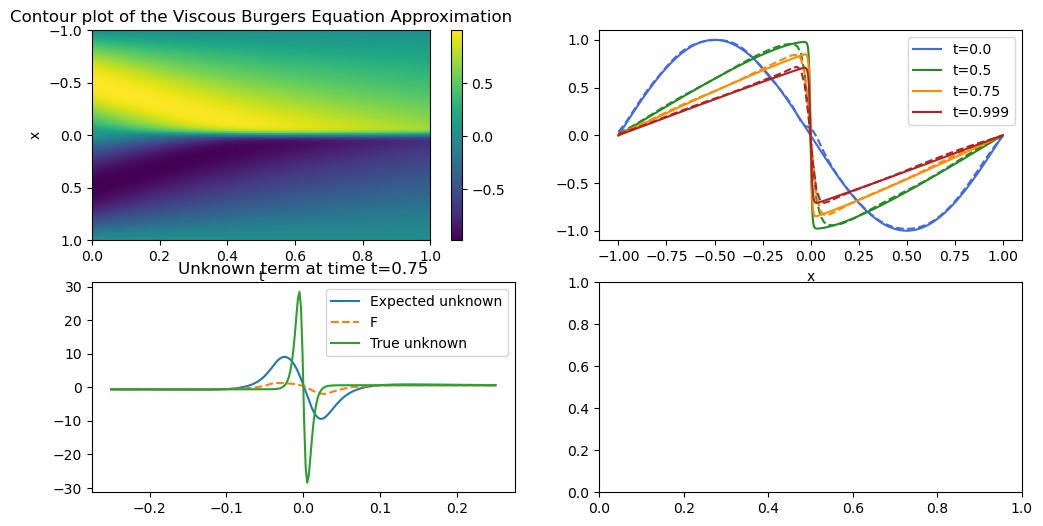

[6000/10001] Boundary L: 0.00017704098718240857, Phys L: 0.004636750090867281, Data L: 0.0021345755085349083


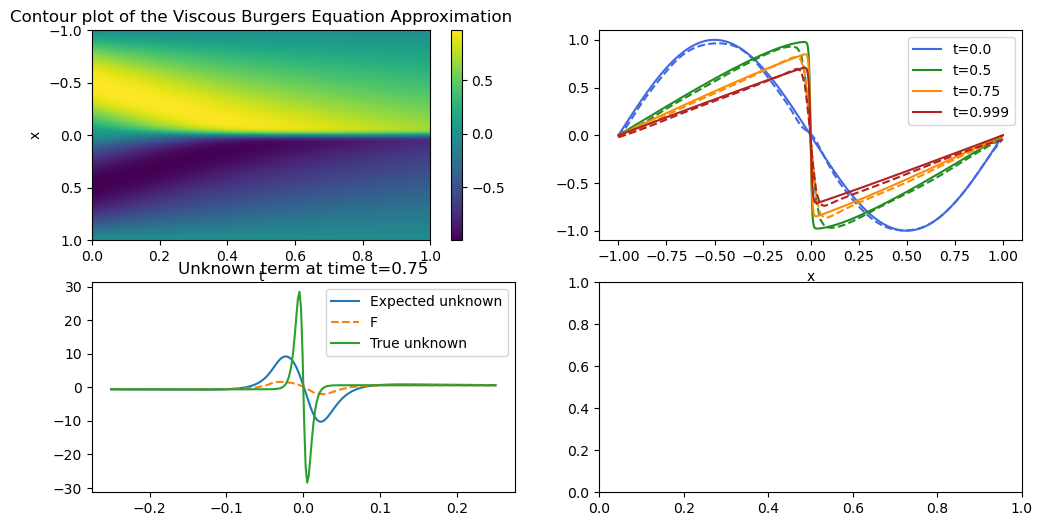

[7000/10001] Boundary L: 0.00023525110736954957, Phys L: 0.00019860896281898022, Data L: 0.001827110187150538


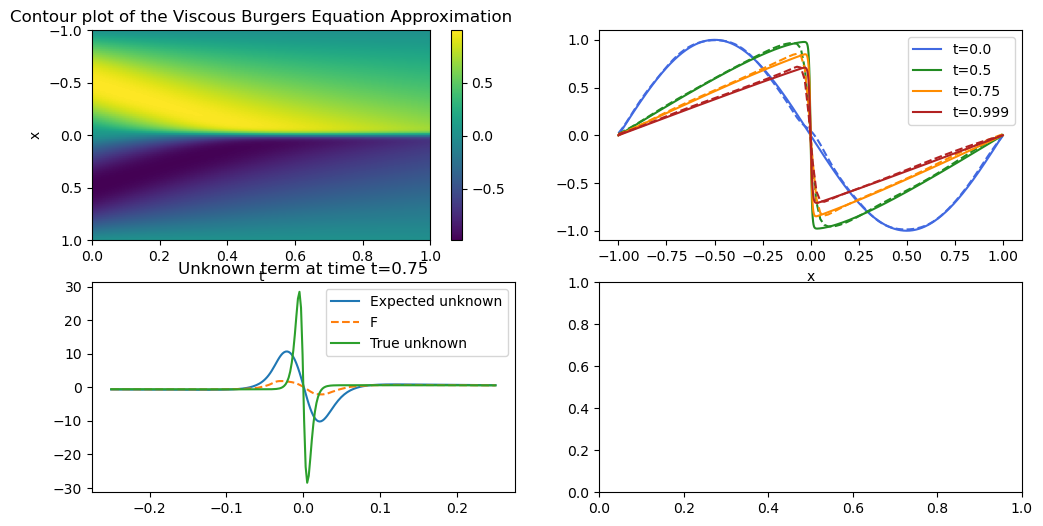

[8000/10001] Boundary L: 0.0007834751741029322, Phys L: 0.0011514457874000072, Data L: 0.0022106708493083715


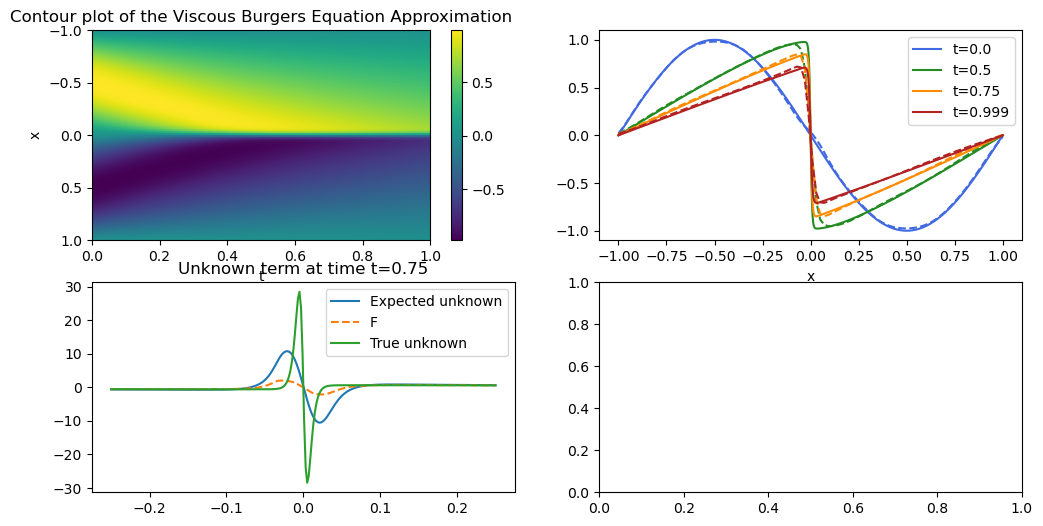

[9000/10001] Boundary L: 0.00012424324813764542, Phys L: 0.00035534429480321705, Data L: 0.0015946176135912538


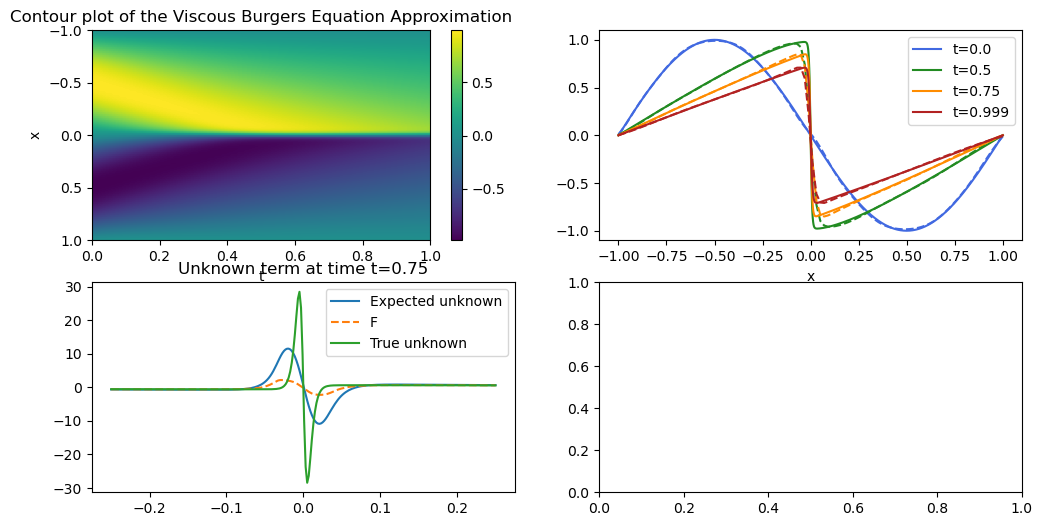

[10000/10001] Boundary L: 0.0001625278382562101, Phys L: 0.0002660901809576899, Data L: 0.0013048159889876842


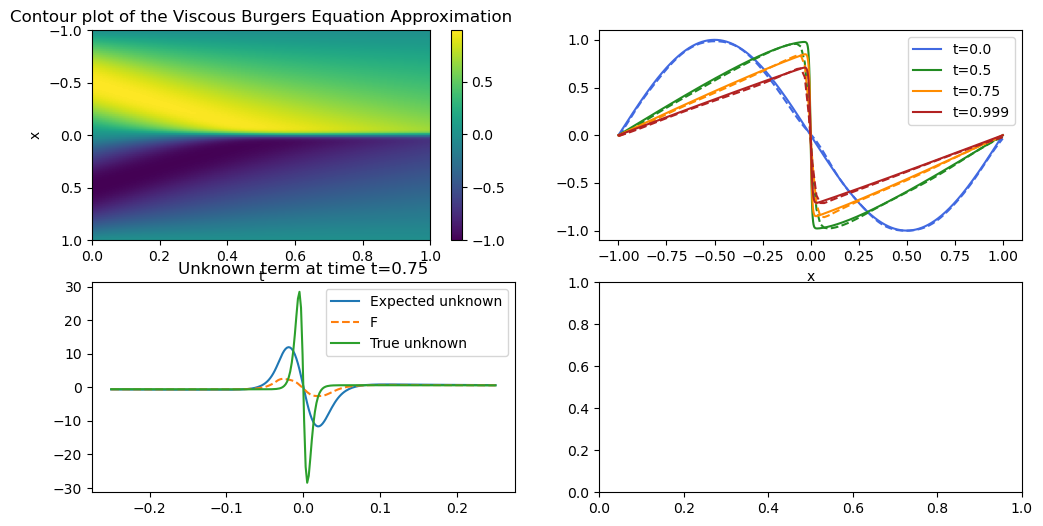

In [59]:
# lr = 2e-2
# optimizer = torch.optim.Adam([*u.parameters(), *f.parameters()], lr=lr) # if you use a shared optimizer
lr_u = 2e-2 #  2e-2
lr_f = 3e-2 #  3e-2
optimizer_u = torch.optim.Adam(u.parameters(), lr=lr_u)
optimizer_f = torch.optim.Adam(f.parameters(), lr=lr_f)

phys_losses = []
losses = []

total_itr = 10001


for i in range(total_itr):
#     optimizer.zero_grad()
    optimizer_u.zero_grad()
    optimizer_f.zero_grad()
    
    tot_loss, loss1, loss2, loss3 = get_loss(boundary_points, boundary_targets, 
                                                         collocation_p, 
                                                         train_data, train_targets,
                                                        lambdas=(3e0, 9e0, 5e0)) # 9e0, 2e1, 5e0
    losses.append(tot_loss.item())
    
    tot_loss.backward()
#     optimizer.step()
    optimizer_u.step()
    optimizer_f.step()
    
    if i% 1000 == 0:
        print(f'[{i}/{total_itr}] Boundary L: {loss1.item()}, Phys L: {loss2.item()}, Data L: {loss3.item()}')
        plot_solution(usol, u, f)


In [60]:
# Save models
torch.save(u.state_dict(), './u_burgers_good.pt')
torch.save(f.state_dict(), './f_burgers_good.pt')

#### Use LBFGS optimizer

In [61]:
from torch.optim import LBFGS
lbfgs_optim = LBFGS([*u.parameters(), *f.parameters()], history_size=20, max_iter=10)

In [64]:
def closure():
    lbfgs_optim.zero_grad()
    tot_loss, _, _, _ = get_loss(boundary_points, boundary_targets, 
                                    collocation_p, 
                                    train_data, train_targets,
                                    lambdas=(3e0, 9e0, 5e0)) # 9e0, 2e1, 5e0 # 
    tot_loss.backward()
    return tot_loss

[                    ] 0%[0/10001]


/tmp/ipykernel_14043/2272388903.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


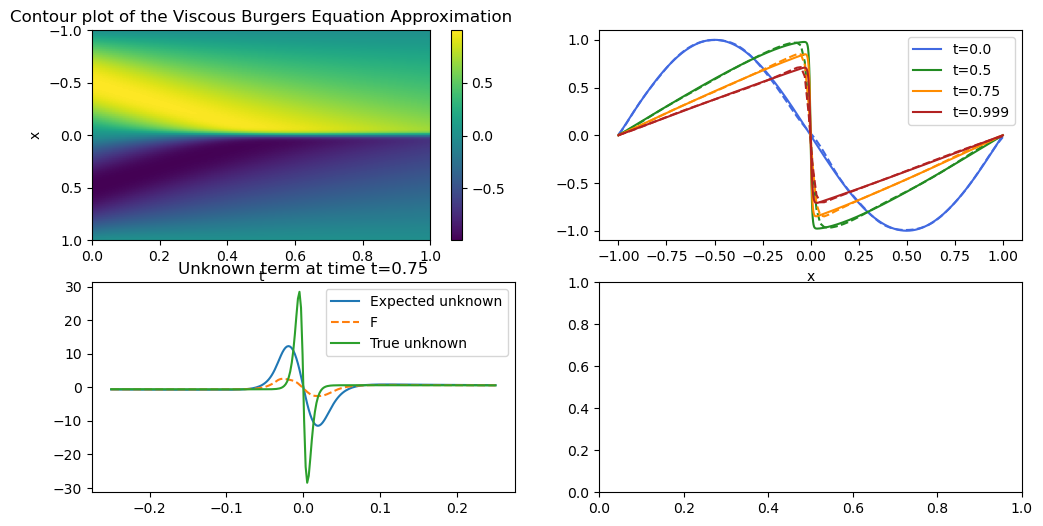

[=                   ] 4%[500/10001]


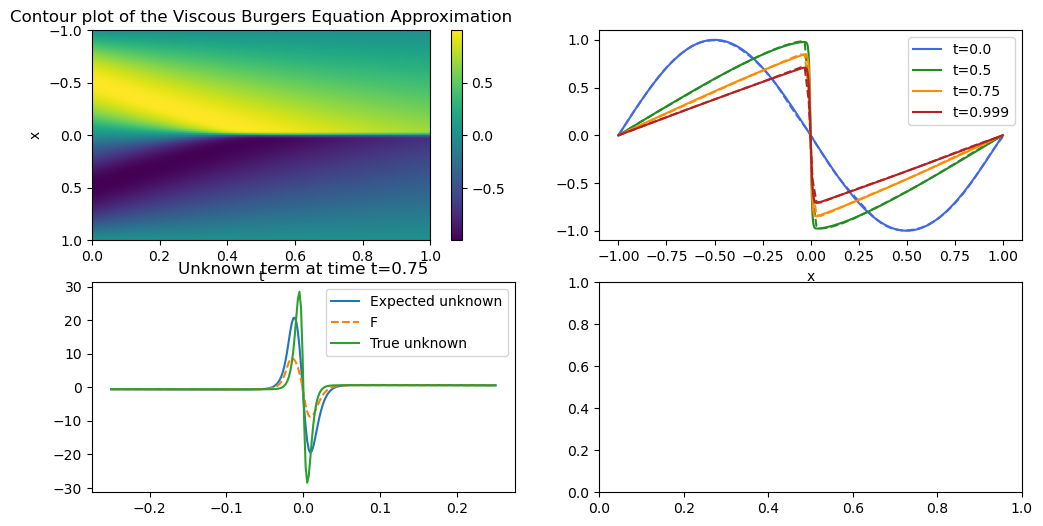

[==                  ] 9%[1000/10001]


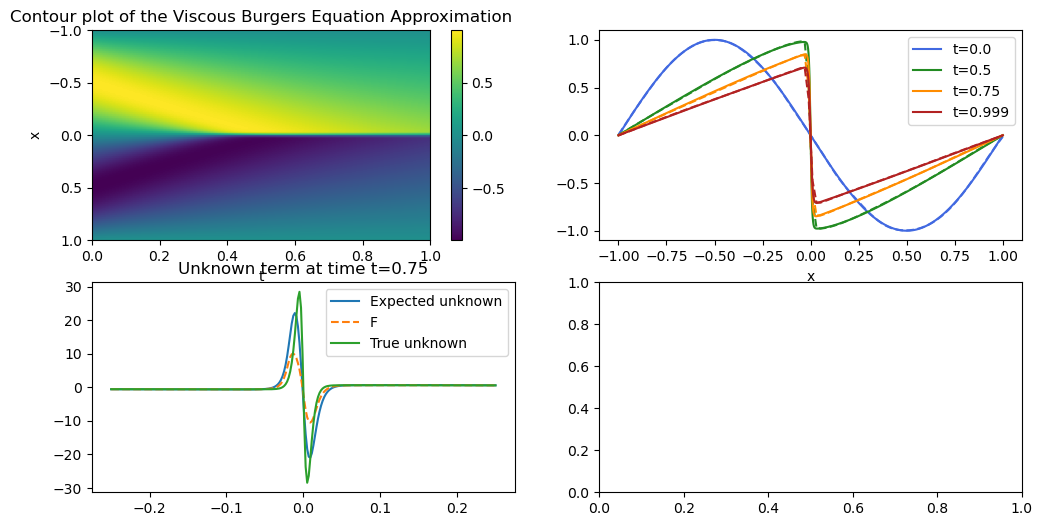

[===                 ] 14%[1500/10001]


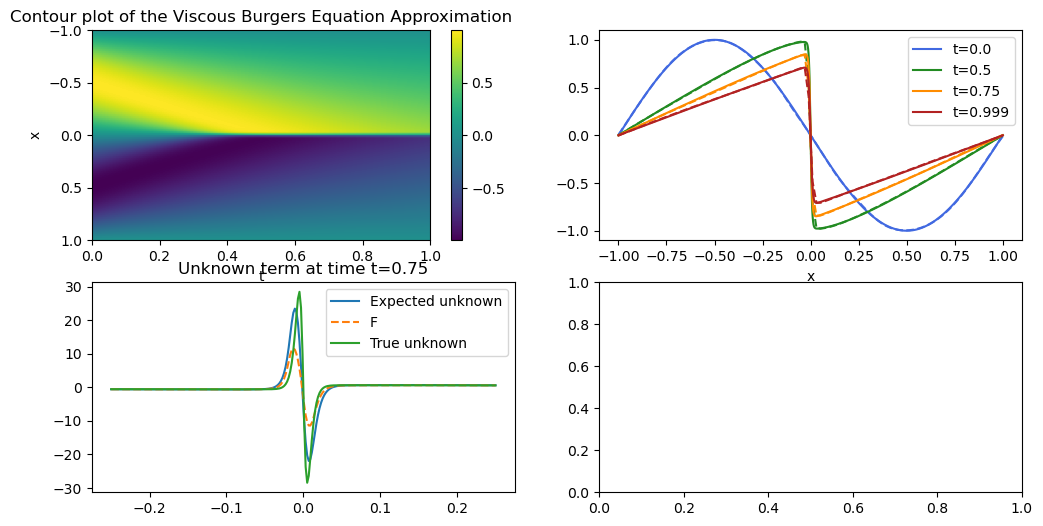

[====                ] 19%[2000/10001]


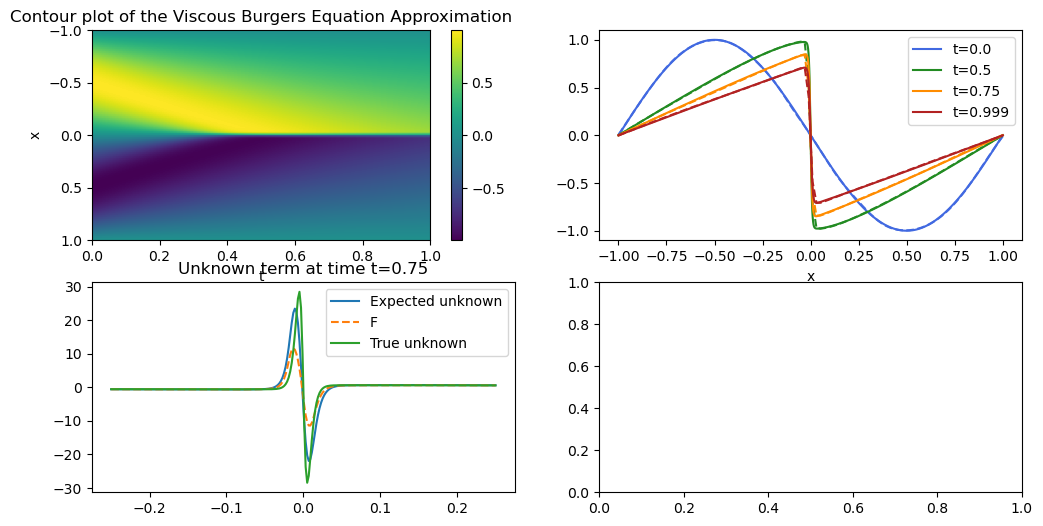

[=====               ] 24%[2500/10001]


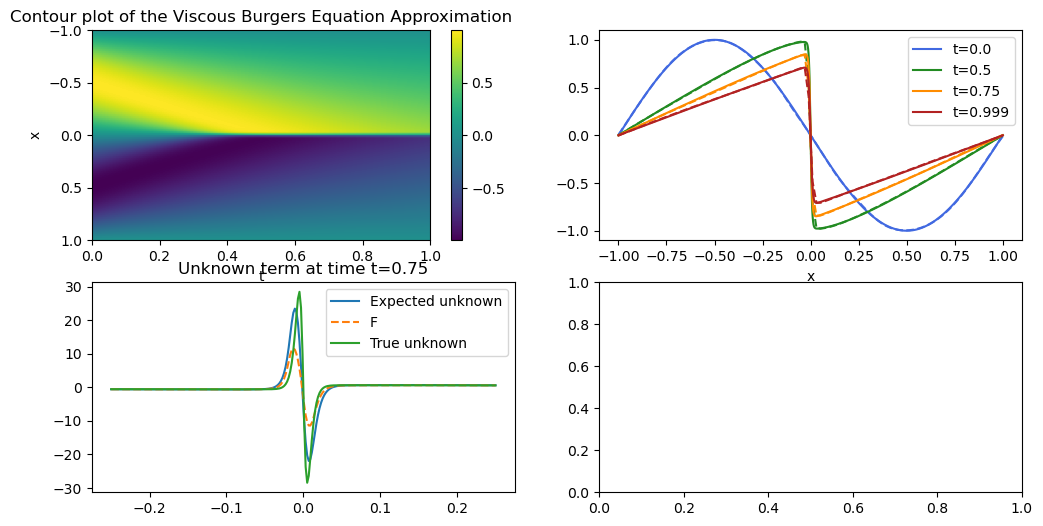

[======              ] 29%[3000/10001]


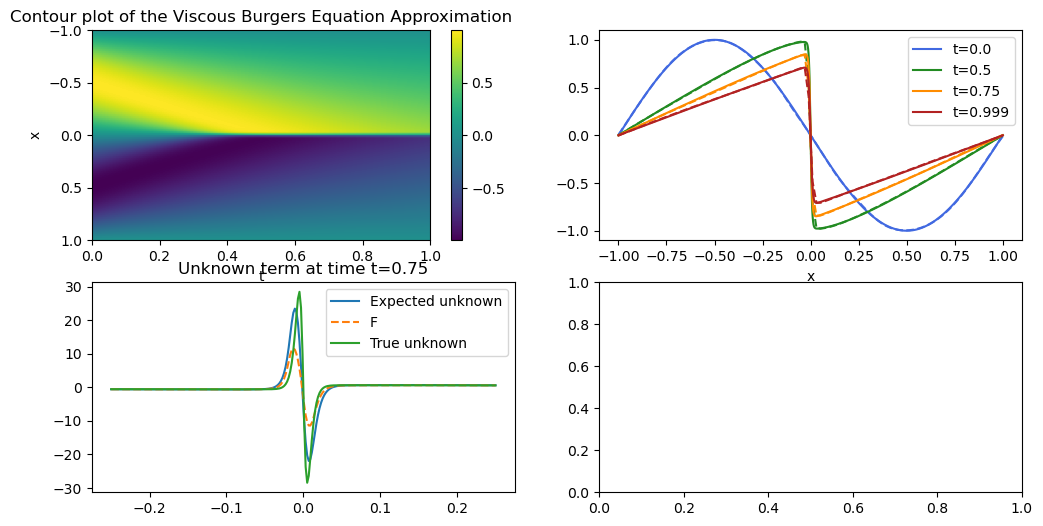

[=======             ] 34%[3500/10001]


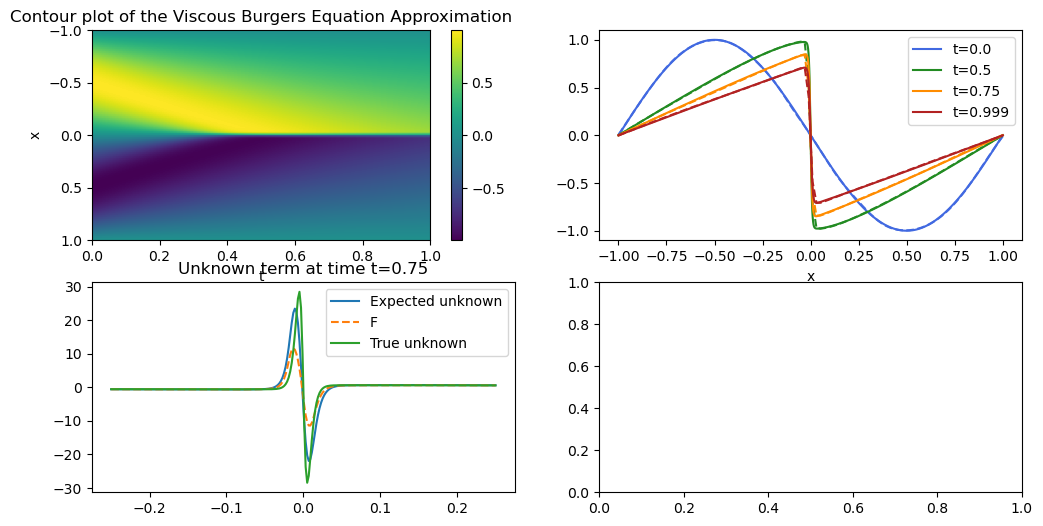

[========            ] 39%[4000/10001]


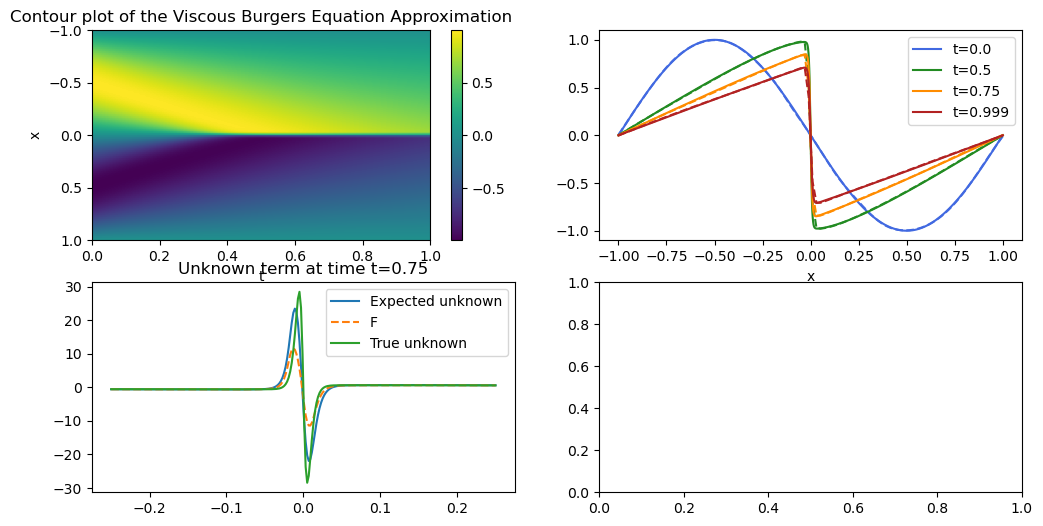

[=========           ] 44%[4500/10001]


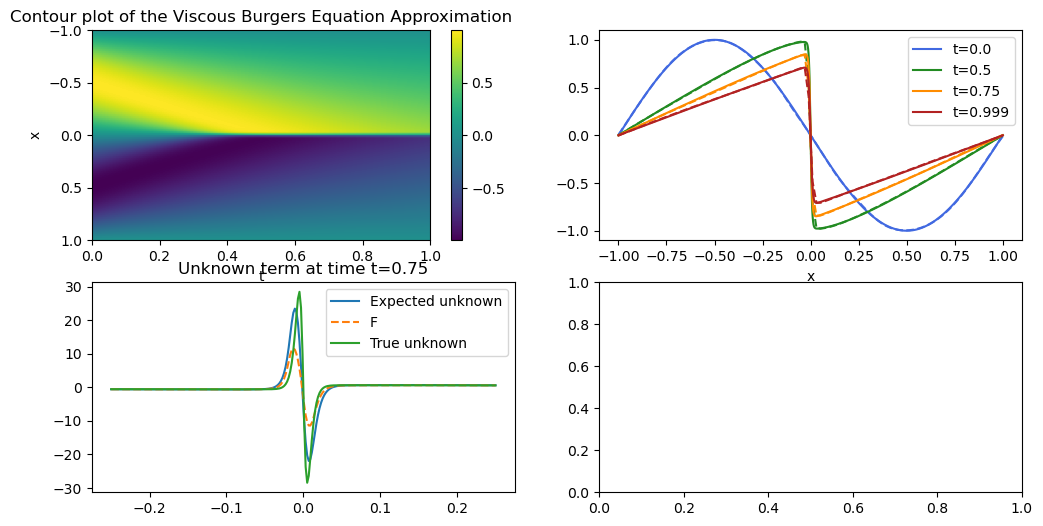

[==========          ] 49%[5000/10001]


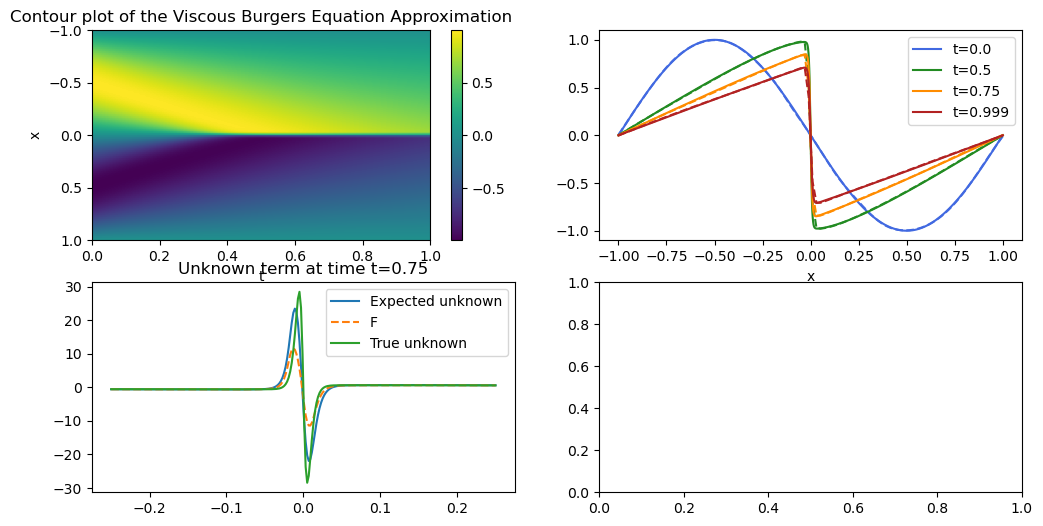

[===========         ] 54%[5500/10001]


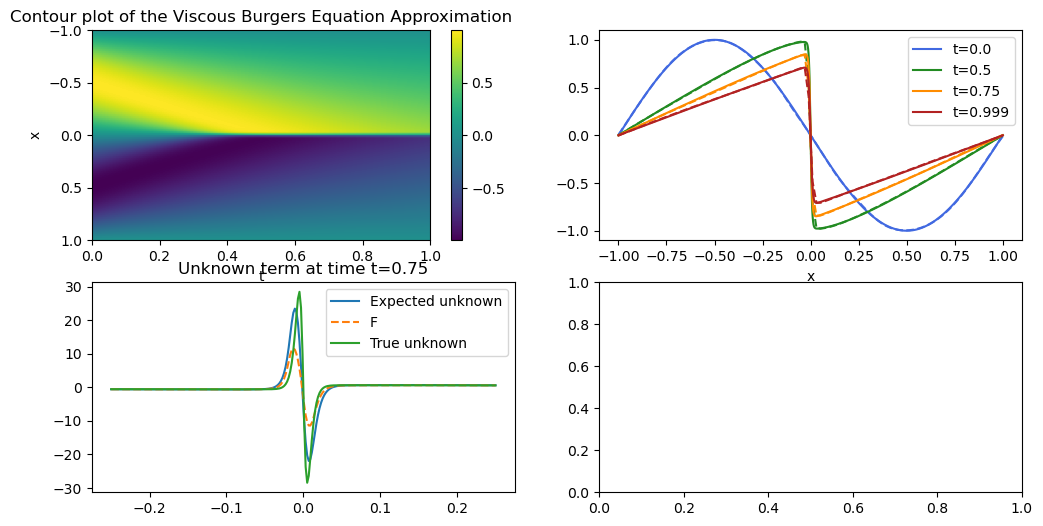

[============        ] 59%[6000/10001]


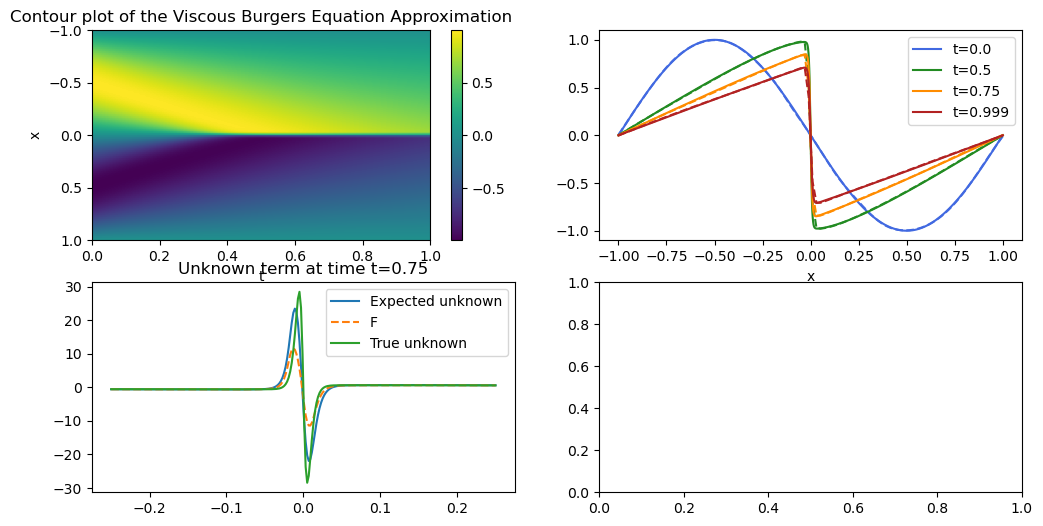

[=============       ] 64%[6500/10001]


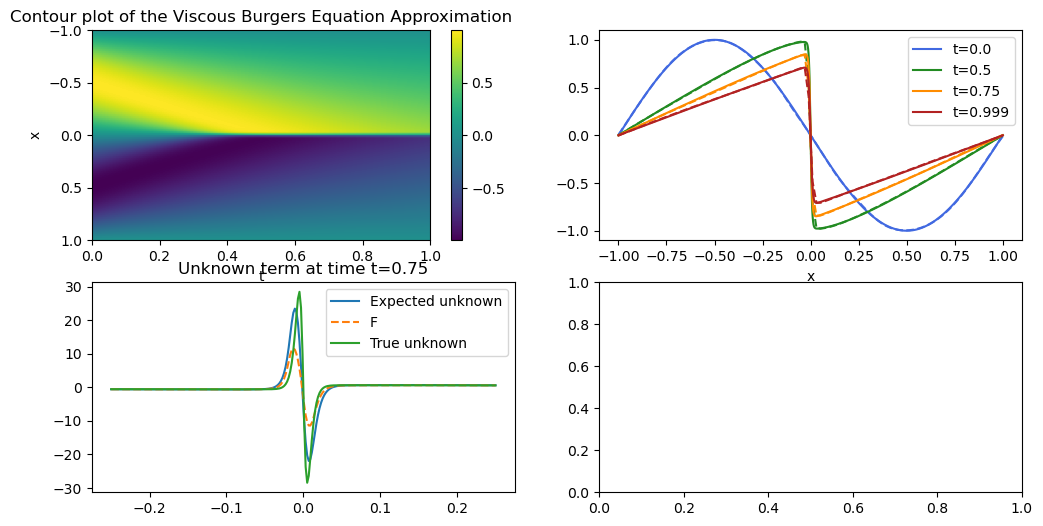

[==============      ] 69%[7000/10001]


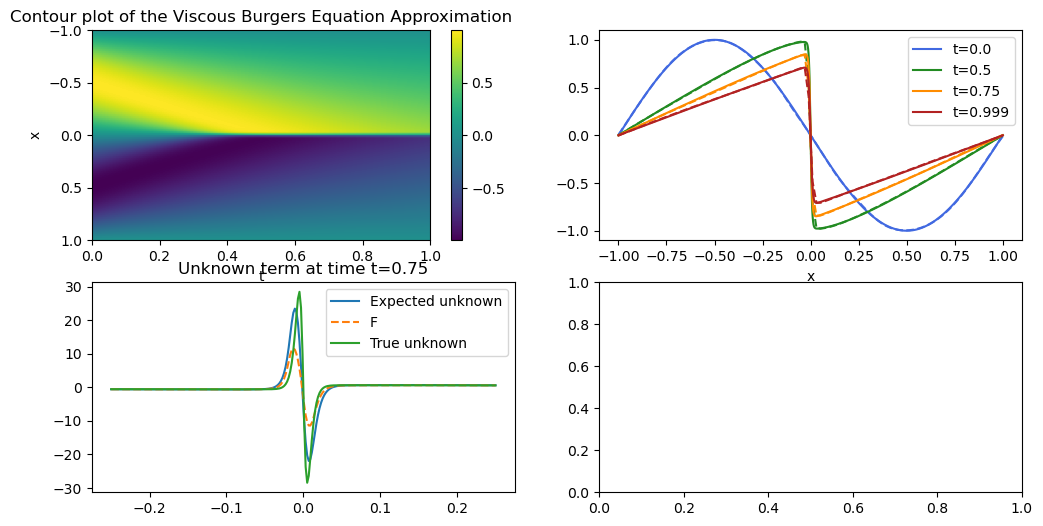

[===============     ] 74%[7500/10001]


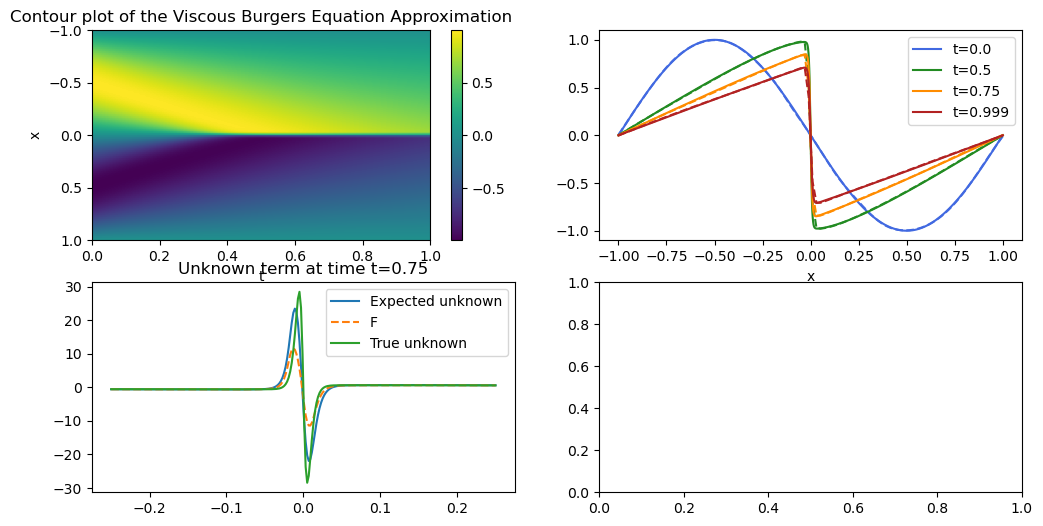

[================    ] 79%[8000/10001]


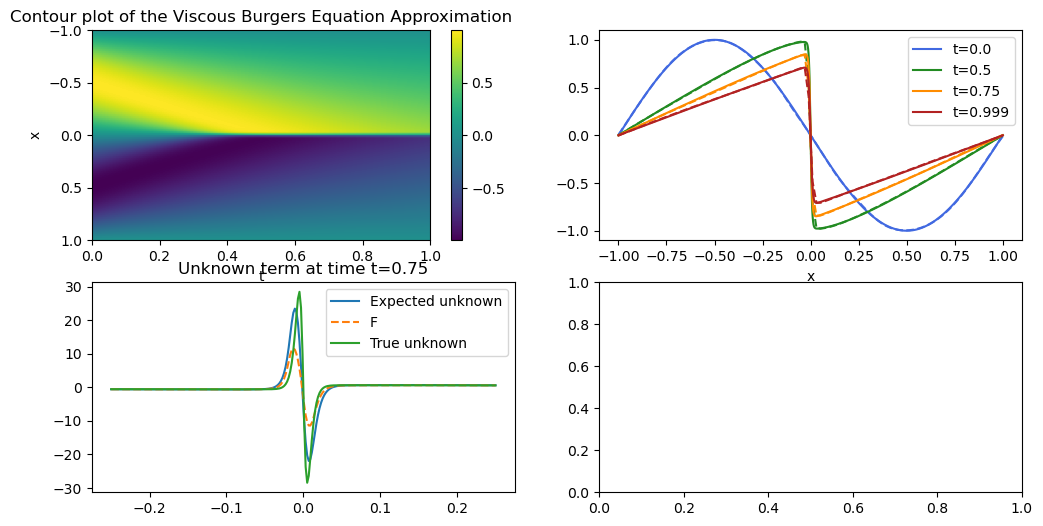

[=================   ] 84%[8500/10001]


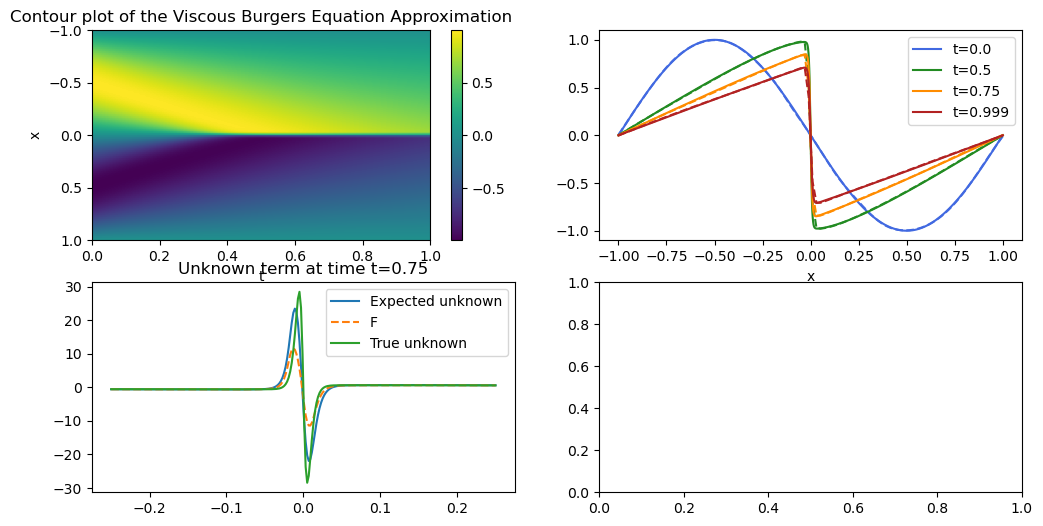

[==================  ] 89%[9000/10001]


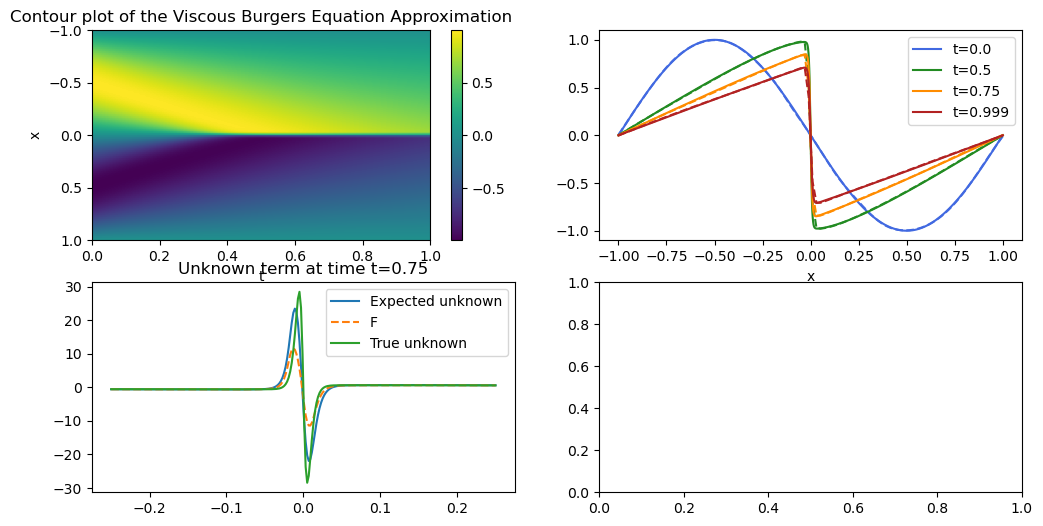

[=================== ] 94%[9500/10001]


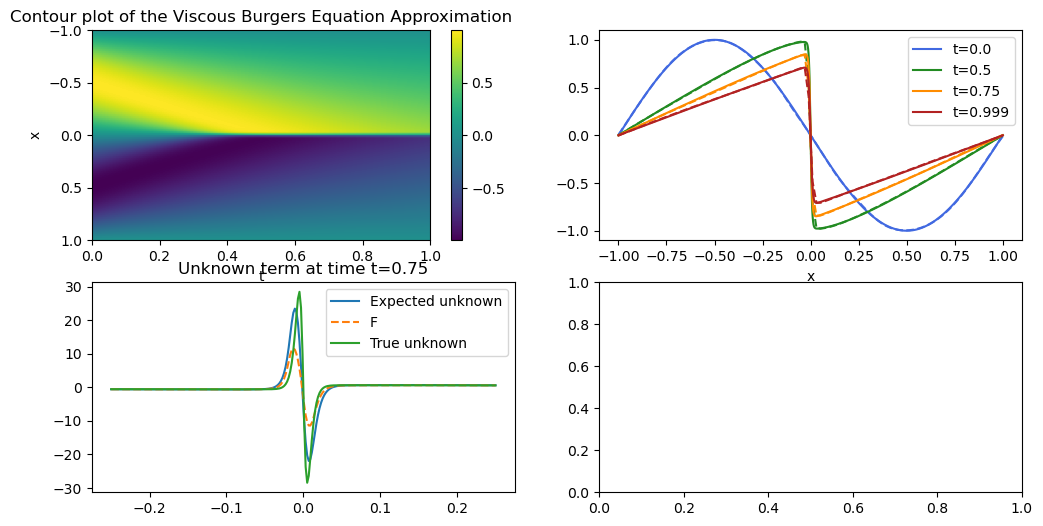

[====================] 99%[10000/10001]


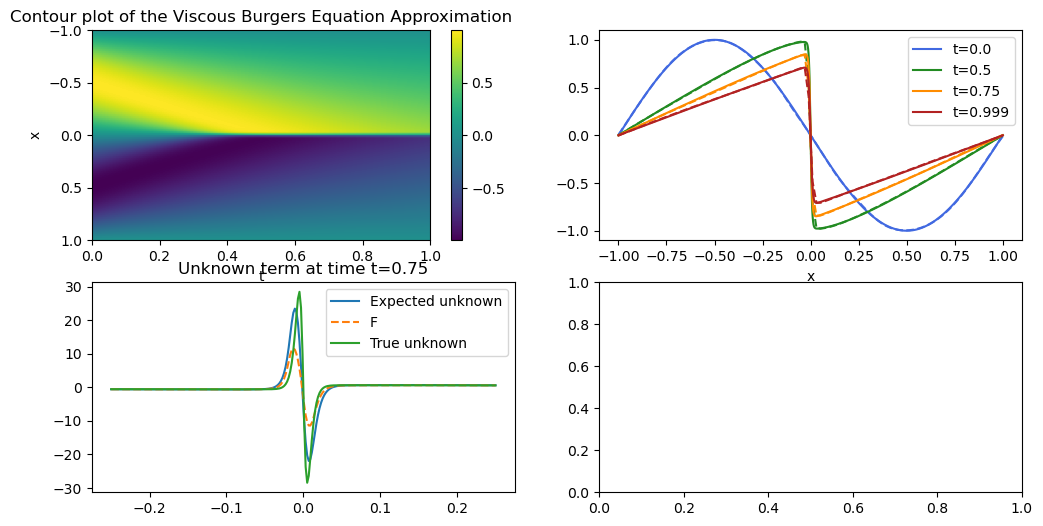

In [65]:
import sys
lbfgs_itr = 10001


for i in range(lbfgs_itr):
    lbfgs_optim.step(closure)
    sys.stdout.write("\r[%-20s] %d%%" % ('=' * (i // (lbfgs_itr // 20)), (i * 100) // lbfgs_itr))
    sys.stdout.flush()
    
    if i%500 == 0:
        print(f'[{i}/{lbfgs_itr}]')
        fig_lbfgs = plot_solution(usol, u, f)

In [66]:
# Save models
torch.save(u.state_dict(), './u_burgers_LBFGS_good.pt')
torch.save(f.state_dict(), './f_burgers_LBFGS_good.pt')

In [67]:
fig_lbfgs.savefig('./burgers_lbfgs_good.pdf')

In [ ]:
# how to: Retrieve the model: 

# u_model = U(2,1, [20]*8)
# checkpoint = torch.load('./path/u_burgers_LBFGS.pt')
# u_model.load_state_dict(checkpoint)# u_model.eval()

# equivalent for f

# try it:
# u_model(torch.Tensor([0,-0.5]))

In [72]:
# plot_solution(usol, u, f, mesh_size=10**2)

/tmp/ipykernel_14043/2272388903.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


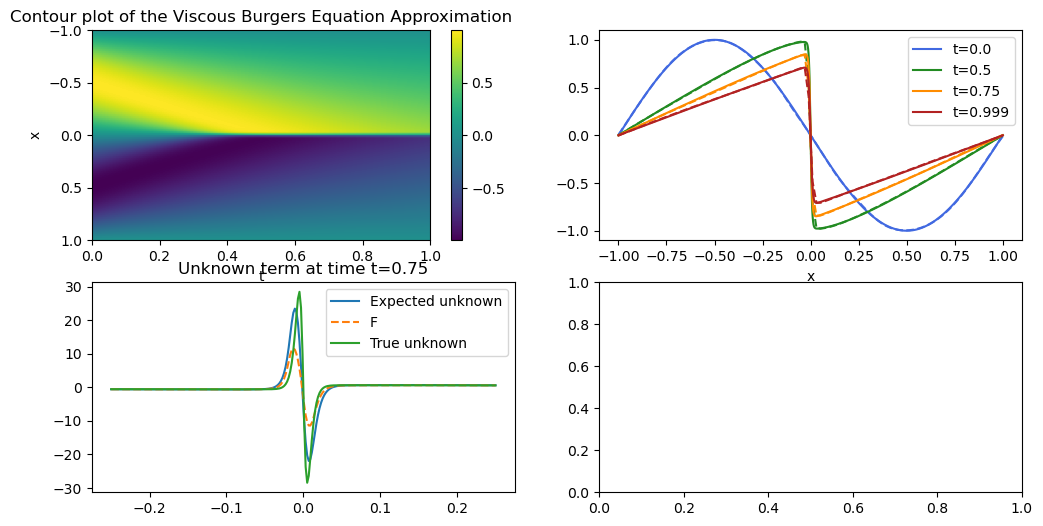

In [73]:
tmp = plot_solution(usol, u, f,mesh_size=10**2)